In [8]:
from IPython.core.display import HTML, display
display(HTML('<style>.container {width:95% !important;} </style>'))

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [10]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

In [11]:
#редуцент для работы на старых версиях
from sklearn.metrics import make_scorer

def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

rmse_scorer = make_scorer(
    rmse,
    greater_is_better=False
)

# Содержание
### [0. Импорт данных и разведочный анализ](#0-import)
### [1. Первая грубая модель](#1-mvp)
### [2. Усложняем модель](#2-vp)

# 0. Импорт данных и разведочный анализ <a class="anchor" id="0-import"></a>

In [12]:
raw_data = pd.read_csv('housing.csv')

In [13]:
raw_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [14]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [15]:
raw_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [16]:
raw_data[['housing_median_age', 'population']].groupby(by=raw_data['ocean_proximity']).mean()

,housing_median_age,population
ocean_proximity,,
<1H OCEAN,29.279225,1520.290499
INLAND,24.271867,1391.046252
ISLAND,42.400000,668.000000
NEAR BAY,37.730131,1230.317467
NEAR OCEAN,29.347254,1354.008653


In [17]:
raw_data['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

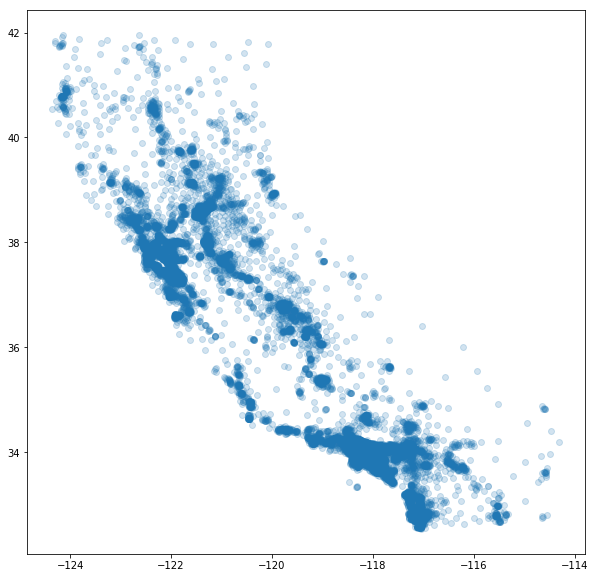

In [18]:
plt.figure(figsize= (10,10))
plt.scatter(raw_data.longitude, raw_data.latitude, alpha = 0.2)

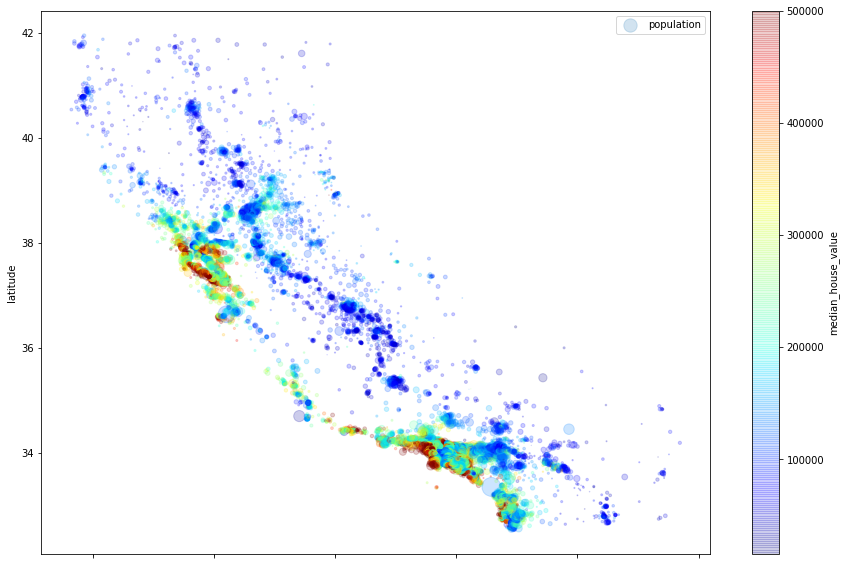

In [19]:
raw_data.plot(kind='scatter', y='latitude', x= 'longitude', figsize=(15,10), alpha=0.2, 
              s = raw_data['population']/100, #отвечает за размер круга
              label = 'population', #тупо название
              
              c = 'median_house_value',
              cmap=plt.get_cmap('jet'),
              colorbar=True #погоды вообще не делает
              )

C:\Users\kaurov.a\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


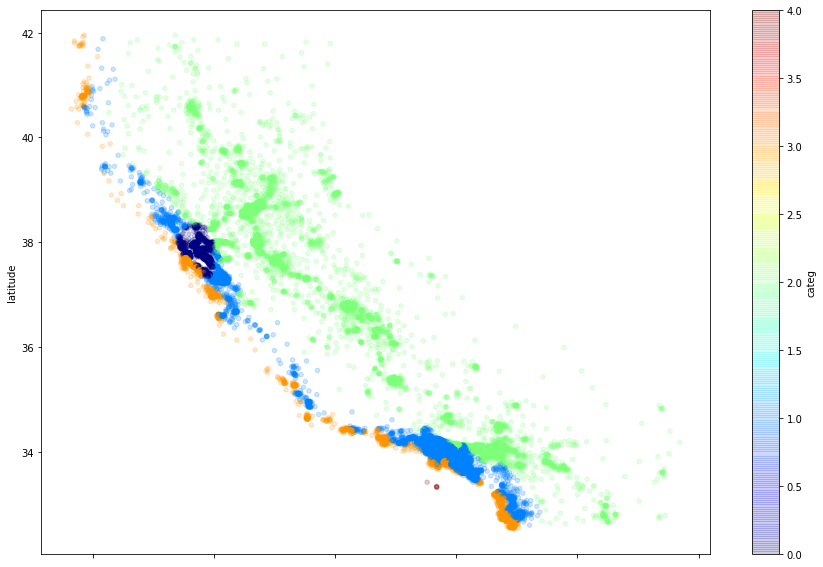

In [20]:
glimpse_ds = raw_data[['longitude', 'latitude']]
glimpse_ds['categ'] = raw_data['ocean_proximity'].factorize()[0]
glimpse_ds.plot(kind='scatter', y='latitude', x= 'longitude', figsize=(15,10), alpha=0.2,            
    c = 'categ',
    cmap=plt.get_cmap('jet'),
    colorbar=True #погоды вообще не делает
    )

In [13]:
from ipyleaflet import Map, Circle, LayerGroup, basemaps

def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    center = (data[latitude_column].mean(), data[longitude_column].mean())
    result_map = Map(center=center, zoom=100, basemap=basemaps.Esri.NatGeoWorldMap)

    circles = []
    for _, row in data.iterrows():
        circles.append(Circle(
            location=(row[latitude_column], row[longitude_column]),
            fill_color=color,
            fill_opacity=0.5,
            radius=3000,
            stroke=False
        ))
    circles_layer = LayerGroup(layers=circles)
    result_map.add_layer(circles_layer)

    return result_map

In [ ]:
show_circles_on_map(raw_data, 'latitude', 'longitude', "blue")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000238D1B91A20>,
      dtype=object)

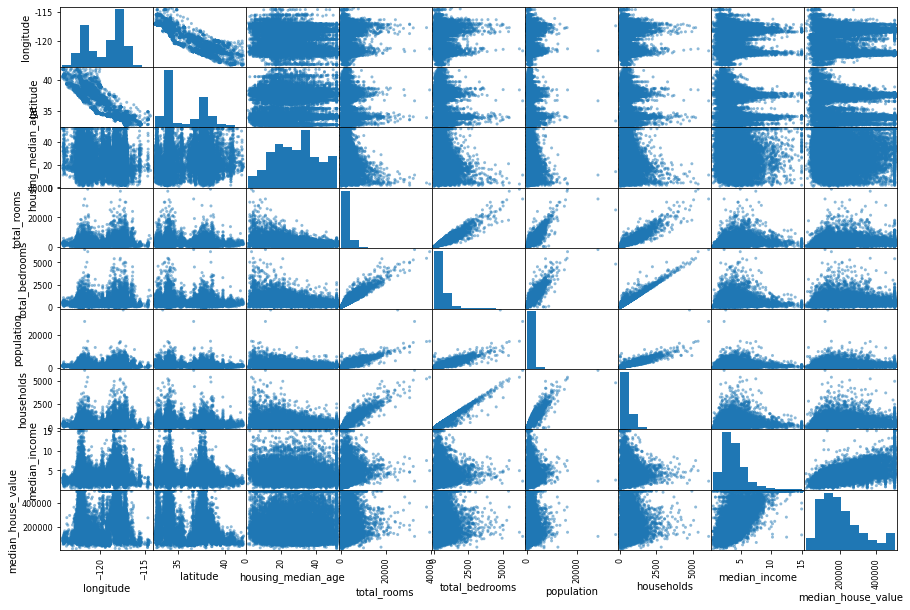

In [15]:
pd.plotting.scatter_matrix(raw_data, figsize= (15,10)) #матрицу переместили в раздел plotting

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000238DCB77FD0>,
      dtype=object)

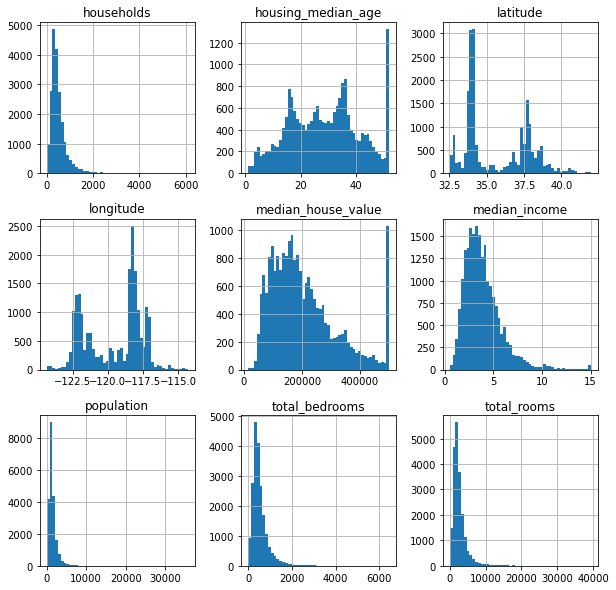

In [16]:
raw_data.hist(bins=50, figsize= (10,10))

# 1. Первая грубая модель <a class="anchor" id="1-mvp"></a>

In [21]:
s1_df = raw_data.copy()

In [22]:
s1_df['total_bedrooms'].fillna(raw_data['total_bedrooms'].mean(), inplace=True)

In [23]:
s1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20640 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [24]:
s1_df = s1_df.select_dtypes(include=['float64'])

In [25]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [28]:
#mvp_columns = s1_df.columns.to_list()[:-1]
mvp_columns = list(s1_df.columns)[:-1]

In [29]:
mvp_columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [30]:
X_mvp = pd.DataFrame(s1_df, columns=mvp_columns)

In [31]:
X_mvp

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912


In [32]:
y_mvp = s1_df.median_house_value

In [33]:
y_mvp

0        452600.0
1        358500.0
2        352100.0
3        341300.0
4        342200.0
5        269700.0
6        299200.0
7        241400.0
8        226700.0
9        261100.0
10       281500.0
11       241800.0
12       213500.0
13       191300.0
14       159200.0
15       140000.0
16       152500.0
17       155500.0
18       158700.0
19       162900.0
20       147500.0
21       159800.0
22       113900.0
23        99700.0
24       132600.0
25       107500.0
26        93800.0
27       105500.0
28       108900.0
29       132000.0
           ...   
20610     45500.0
20611     47000.0
20612     48300.0
20613     53400.0
20614     58000.0
20615     57500.0
20616     55100.0
20617     70800.0
20618     63400.0
20619     99100.0
20620    100000.0
20621     77500.0
20622     67000.0
20623     65500.0
20624     87200.0
20625     72000.0
20626     93800.0
20627    162500.0
20628     92400.0
20629    108300.0
20630    112000.0
20631    107200.0
20632    115600.0
20633     98300.0
20634    1

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_mvp, y_mvp, test_size = 0.3, random_state = 42)

In [35]:
X_train

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
7061,-118.02,33.93,35.0,2400.0,398.0,1218.0,408.0,4.1312
14689,-117.09,32.79,20.0,2183.0,534.0,999.0,496.0,2.8631
17323,-120.14,34.59,24.0,1601.0,282.0,731.0,285.0,4.2026
10056,-121.00,39.26,14.0,810.0,151.0,302.0,138.0,3.1094
15750,-122.45,37.77,52.0,3188.0,708.0,1526.0,664.0,3.3068
15283,-117.33,33.17,11.0,10923.0,2041.0,4773.0,1858.0,4.0791
18551,-122.03,36.96,28.0,1607.0,421.0,926.0,385.0,2.4250
7555,-118.19,33.91,33.0,915.0,225.0,826.0,212.0,2.7708
15700,-122.44,37.79,52.0,1817.0,535.0,800.0,487.0,3.9750
12364,-116.46,33.82,6.0,4863.0,920.0,3010.0,828.0,3.9508


In [36]:
X_test

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
20046,-119.01,36.06,25.0,1505.0,537.870553,1392.0,359.0,1.6812
3024,-119.46,35.14,30.0,2943.0,537.870553,1565.0,584.0,2.5313
15663,-122.44,37.80,52.0,3830.0,537.870553,1310.0,963.0,3.4801
20484,-118.72,34.28,17.0,3051.0,537.870553,1705.0,495.0,5.7376
9814,-121.93,36.62,34.0,2351.0,537.870553,1063.0,428.0,3.7250
13311,-117.61,34.08,12.0,4427.0,537.870553,2400.0,843.0,4.7147
7113,-118.02,33.89,36.0,1375.0,537.870553,670.0,221.0,5.0839
7668,-118.08,33.92,38.0,1335.0,537.870553,1011.0,269.0,3.6908
18246,-122.08,37.39,4.0,2292.0,537.870553,1050.0,584.0,4.8036
5723,-118.23,34.18,45.0,2332.0,537.870553,943.0,339.0,8.1132


In [37]:
model = Ridge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [38]:
print('train RMSE ', mean_squared_error(y_train, y_pred_train, squared=False))
print('test RMSE', mean_squared_error(y_test, y_pred, squared=False))

TypeError: mean_squared_error() got an unexpected keyword argument 'squared'

C:\Users\kaurov.a\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


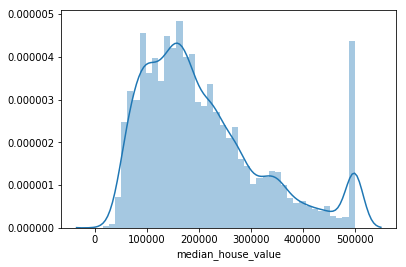

In [39]:
sns.distplot(y_train)

# 2.  Усложняем модель <a class="anchor" id="2-vp"></a>

In [40]:
s2_df = raw_data.copy()
s2_df['total_bedrooms'].fillna(float(raw_data['total_bedrooms'].mean()), inplace=True)
#vp_columns = s2_df.columns.to_list()[:-1] #в старых версиях не работает
#vp_columns = list(s2_df.columns).remove('median_house_value')
vp_columns = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']
y_s2 = s2_df['median_house_value']
X_s2 = s2_df[vp_columns]

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_s2, y_s2, test_size=0.3, random_state=40)

In [42]:
X_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14827,-117.09,32.66,37.0,1232.0,330.0,1086.0,330.0,1.6389,NEAR OCEAN
12640,-121.45,38.53,34.0,1893.0,415.0,884.0,395.0,2.1679,INLAND
6016,-117.78,34.06,33.0,1056.0,272.0,964.0,300.0,2.4464,INLAND
13650,-117.31,34.08,37.0,953.0,231.0,611.0,230.0,1.9926,INLAND
13275,-117.63,34.10,15.0,4799.0,1209.0,2554.0,1057.0,2.6582,INLAND


In [43]:
numeric_features = list(X_train.select_dtypes(np.number).columns)

In [44]:
numeric_features

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [45]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

model2 = Ridge()
model2.fit(X_train_scaled, y_train)
y2_pred = model2.predict(X_test_scaled)
y2_train_pred = model2.predict(X_train_scaled)

print(mean_squared_error(y_train, y2_train_pred)**0.5) #, squared = False)
print(mean_squared_error(y_test, y2_pred)**0.5) #, squared = False)

69209.39864371817
70746.73285729329


Best alpha = 14.3845


Text(0, 0.5, 'CV score')

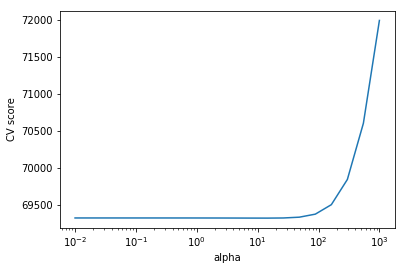

In [46]:
alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring=rmse_scorer, cv=10)
searcher.fit(X_train_scaled, y_train)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [104]:
col_transformer = ColumnTransformer('ohe', OneHotEncoder(handle_unknown="ignore"), 'ocean_proximity')
col_transformer.fit_transform(X_train, y_train)

ValueError: not enough values to unpack (expected 3, got 1)

###  <font color='red'> Загоняем всё в пайплайн </font>

In [31]:
col_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), ['ocean_proximity']), 
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps= [
    ('ohe_and_scaling', col_transformer), 
    ('regression', Ridge(best_alpha))
    ])

In [36]:
model2 = pipeline.fit(X_train, y_train)
y2_pred = model2.predict(X_test)
y2_train_pred = model2.predict(X_train)

print(mean_squared_error(y2_train_pred, y_train, squared=False))
print(mean_squared_error(y2_pred, y_test, squared=False))

68325.89469597006
69779.11843200448


In [47]:
from sklearn.ensemble import RandomForestRegressor

In [48]:
model_rf = RandomForestRegressor()
model_rf.fit(X_train[numeric_features], y_train)
y_rf_train_pred = model_rf.predict(X_train[numeric_features])
mean_squared_error(y_train, y_rf_train_pred, squared=False)

C:\Users\kaurov.a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TypeError: mean_squared_error() got an unexpected keyword argument 'squared'

In [67]:
scores = cross_val_score(model_rf, X_train[numeric_features], y_train, scoring='neg_mean_squared_error', cv=10)

In [68]:
scores

array([-2.60073827e+09, -2.68355346e+09, -2.65414092e+09, -2.81173116e+09,
       -2.94210612e+09, -2.47609699e+09, -2.83865675e+09, -2.47895468e+09,
       -2.60283463e+09, -2.45865503e+09])

In [69]:
tree_scores = np.sqrt(-scores)

In [74]:
tree_scores[1:2]

array([51803.02558894])

## Теперь необходимо отрисовать кривые обучения

In [90]:
X_train, X_val, y_train, y_val = train_test_split(X_mvp, y_mvp, test_size = 0.2, random_state=42)

In [92]:
from sklearn.linear_model import LinearRegression
model_c = LinearRegression()

train_errors, val_errors = [], []
for i in range(1, len(X_train)):
    model_c.fit(X_train.iloc[:i], y_train.iloc[:i])
    y_train_pred = model_c.predict(X_train.iloc[:i])
    y_val_pred = model_c.predict(X_val)
    train_errors.append(mean_squared_error(y_train.iloc[:i], y_train_pred)**0.5)
    val_errors.append(mean_squared_error(y_val, y_val_pred)**0.5)

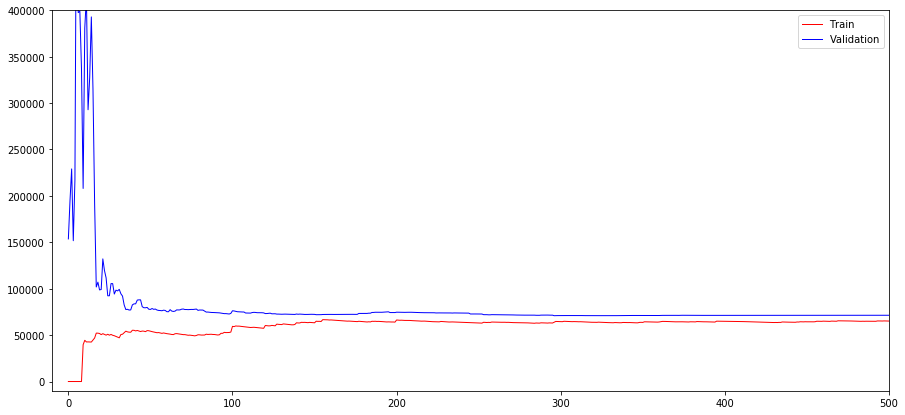

In [113]:
ax = plt.figure(figsize = (15, 7)).add_subplot(1,1,1)
plt.plot(train_errors, 'r-', linewidth = 1, label = 'Train')
plt.plot(val_errors, 'b-', linewidth = 1, label = 'Validation')
ax.set_xlim(-10, 500)
ax.set_ylim(-10000, 400000)
ax.legend()